In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install wandb tensorflow keras gradio

In [14]:
# Celda 1: Configuración inicial y preparación de datos para VAEs individuales

import os, glob, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbCallback
import gc

# Semilla para reproducibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Definir tamaño de imagen (asumiendo imágenes cuadradas, ej. 512x512)
IMG_SIZE = 256 # Reduced image size

# Rutas de las carpetas de imágenes (ajusta los paths según tu estructura)
folder_motorcycle = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/_motorcycles_ - Buscar con Google"
folder_clock = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/clock_2"  # Ajusta el path para imágenes de clock

# Obtener rutas de imágenes
paths_motorcycle = glob.glob(os.path.join(folder_motorcycle, "*"))
paths_clock = glob.glob(os.path.join(folder_clock, "*"))

# Mezclar aleatoriamente
random.shuffle(paths_motorcycle)
random.shuffle(paths_clock)

def split_paths(paths):
    num = len(paths)
    train = paths[:int(0.7 * num)]
    val   = paths[int(0.7 * num):int(0.85 * num)]
    test  = paths[int(0.85 * num):]
    return train, val, test

# Dividir rutas por clase
train_paths_moto, val_paths_moto, test_paths_moto = split_paths(paths_motorcycle)
train_paths_clock, val_paths_clock, test_paths_clock = split_paths(paths_clock)

# Función de preprocesamiento (carga y normaliza la imagen a [0,1])
def preprocess_image(image_path, img_size=IMG_SIZE):
    img = load_img(image_path, target_size=(img_size, img_size)) # Use the reduced IMG_SIZE
    img = img_to_array(img) / 255.0
    return img

# Cargar y preprocesar imágenes para cada clase
X_train_moto = np.array([preprocess_image(p) for p in train_paths_moto])
X_val_moto   = np.array([preprocess_image(p) for p in val_paths_moto])
X_test_moto  = np.array([preprocess_image(p) for p in test_paths_moto])

X_train_clock = np.array([preprocess_image(p) for p in train_paths_clock])
X_val_clock   = np.array([preprocess_image(p) for p in val_paths_clock])
X_test_clock  = np.array([preprocess_image(p) for p in test_paths_clock])

print("Motorcycle - Train:", X_train_moto.shape, "Val:", X_val_moto.shape, "Test:", X_test_moto.shape)
print("Clock - Train:", X_train_clock.shape, "Val:", X_val_clock.shape, "Test:", X_test_clock.shape)

# Liberar memoria si es necesario
gc.collect()

Motorcycle - Train: (152, 256, 256, 3) Val: (33, 256, 256, 3) Test: (33, 256, 256, 3)
Clock - Train: (243, 256, 256, 3) Val: (52, 256, 256, 3) Test: (53, 256, 256, 3)


15293

In [18]:
# Celda 2: Definición de la arquitectura VAE

from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

class VAE(Model):
    def __init__(self, encoder, decoder, img_size=IMG_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.img_size = img_size
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def vae_loss(self, y_true, y_pred, z_mean, z_log_var):
        reconstruction_loss = tf.keras.losses.mse(K.flatten(y_true), K.flatten(y_pred))
        reconstruction_loss *= self.img_size * self.img_size * 3
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = -0.5 * tf.reduce_mean(kl_loss)
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss = self.vae_loss(data, reconstruction, z_mean, z_log_var)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(loss - self.kl_loss_tracker.result())
        self.kl_loss_tracker.update_state(self.kl_loss_tracker.result())
        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs): # Añadido el método call para el forward pass
        z = self.encoder(inputs)[2] # Toma el tercer output del encoder (z)
        reconstructed = self.decoder(z) # Pasa z por el decoder
        return reconstructed


def build_vae(latent_dim, img_size=IMG_SIZE):
    # --- Encoder ---
    encoder_inputs = Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    # Obtener medias y log-varianzas
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Truco de reparametrización
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean), seed=seed)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # --- Decoder ---
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense((img_size // 16) * (img_size // 16) * 256, activation='relu')(latent_inputs) # No change needed as //16 adapts
    x = layers.Reshape((img_size // 16, img_size // 16, 256))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    vae = VAE(encoder, decoder, img_size=img_size)
    return vae, encoder, decoder

In [21]:
# Celda 3: Instanciar y compilar los VAEs para cada clase

LATENT_DIM = 256  # Puedes ajustar este valor según tus experimentos

# VAE para Motorcycle
vae_moto, encoder_moto, decoder_moto = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer_moto = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae_moto.compile(optimizer=optimizer_moto, loss=tf.keras.losses.mse) # Added loss function here


# VAE para Clock
vae_clock, encoder_clock, decoder_clock = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer_clock = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae_clock.compile(optimizer=optimizer_clock, loss=tf.keras.losses.mse) # Added loss function here

# Mostrar resúmenes de ambos modelos
vae_moto.summary()
vae_clock.summary()

Model: "vae_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 256), (None, 256),  │      68,025,024 │
│                                      │ (None, 256))                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 256, 256, 3)         │      17,822,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,847,939 (327.48 MB)

 Trainable params: 85,846,019 (327.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "vae_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 256), (None, 256),  │      68,025,024 │
│                                      │ (None, 256))                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 256, 256, 3)         │      17,822,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,847,939 (327.48 MB)

 Trainable params: 85,846,019 (327.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [22]:
# Celda 4: Entrenamiento de los VAEs individuales con registro en WandB

# --- VAE para Motorcycle ---
wandb.login(key="84acb992804885251a1080b55a34890b5cec77eb")
run_moto = wandb.init(entity="arturo-torres-iteso", project="VAE + DAE", name="VAE_Motorcycle_256_IMG_SIZE", reinit=True) # Changed run name
# run_moto = wandb.init(entity="arturo-torres-iteso", project="VAE + DAE", name="VAE_Motorcycle", reinit=True)

history_moto = vae_moto.fit(
    X_train_moto,
    X_train_moto,
    epochs=100,            # Ajusta las épocas según necesidad
    batch_size=4,         # Reduced batch size
    validation_data=(X_val_moto, X_val_moto),
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar pesos del modelo en WandB
vae_moto.save("vae_moto_model_256_IMG_SIZE.h5") # Changed saved model name
wandb.save("vae_moto_model_256_IMG_SIZE.h5") # Changed saved model name
wandb.finish()

tf.keras.backend.clear_session()
gc.collect()

# --- VAE para Clock ---
run_clock = wandb.init(project="VAE + DAE", name="VAE_Clock_256_IMG_SIZE", reinit=True) # Changed run name
# run_clock = wandb.init(project="VAE + DAE", name="VAE_Clock", reinit=True)

history_clock = vae_clock.fit(
    X_train_clock,
    X_train_clock,
    epochs=50,            # Ajusta las épocas según necesidad
    batch_size=4,         # Reduced batch size
    validation_data=(X_val_clock, X_val_clock),
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar pesos del modelo en WandB
vae_clock.save("vae_clock_model_256_IMG_SIZE.h5") # Changed saved model name
wandb.save("vae_clock_model_256_IMG_SIZE.h5") # Changed saved model name
wandb.finish()

tf.keras.backend.clear_session()
gc.collect()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - kl_loss: 0.0000e+00 - loss: 29999.2344 - reconstruction_loss: 29999.2344 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - kl_loss: 0.0000e+00 - loss: 21187.9883 - reconstruction_loss: 21187.9883 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - kl_loss: 0.0000e+00 - loss: 18448.8359 - reconstruction_loss: 18448.8359 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - kl_loss: 0.0000e+00 - loss: 17407.6777 - reconstruction_loss: 17407.6777 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - kl_loss: 0.0000e+00 - loss: 16539.0000 - reconstruction_loss: 16539.0000 - val_kl_loss:

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▆▅▅▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
kl_loss,0
loss,2769.60474
reconstruction_loss,2769.60474


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - kl_loss: 0.0000e+00 - loss: 26389.8438 - reconstruction_loss: 26389.8438 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - kl_loss: 0.0000e+00 - loss: 21201.5254 - reconstruction_loss: 21201.5254 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - kl_loss: 0.0000e+00 - loss: 18687.4688 - reconstruction_loss: 18687.4688 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - kl_loss: 0.0000e+00 - loss: 16818.1465 - reconstruction_loss: 16818.1465 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - kl_loss: 0.0000e+00 - loss: 13240.0410 - reconstruction_loss: 13240.0410 - val_kl_loss: 0.000

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
kl_loss,0
loss,3890.83887
reconstruction_loss,3890.83887


0

In [23]:
# Celda 5: Evaluación de los VAEs utilizando la métrica MVD

def calc_mvd(real_images, gen_images):
    real_flat = real_images.reshape(real_images.shape[0], -1)
    gen_flat = gen_images.reshape(gen_images.shape[0], -1)
    mean_real = np.mean(real_flat, axis=0)
    std_real = np.std(real_flat, axis=0)
    mean_gen = np.mean(gen_flat, axis=0)
    std_gen = np.std(gen_flat, axis=0)
    mean_distance = np.linalg.norm(mean_real - mean_gen)
    std_distance = np.linalg.norm(std_real - std_gen)
    return mean_distance + std_distance

# Evaluación para Motorcycle VAE
n_samples_moto = len(X_test_moto)
z_samples_moto = np.random.normal(size=(n_samples_moto, LATENT_DIM))
gen_images_moto = decoder_moto.predict(z_samples_moto)
mvd_moto = calc_mvd(X_test_moto, gen_images_moto)
print(f"Motorcycle VAE - Mean and Variance Distance (MVD): {mvd_moto:.2f}")

# Registrar métrica en WandB
run_eval_moto = wandb.init(project="VAE + DAE", name="VAE_Motorcycle_Evaluation", reinit=True)
wandb.log({"MVD_Motorcycle": mvd_moto})
wandb.finish()

# Evaluación para Clock VAE
n_samples_clock = len(X_test_clock)
z_samples_clock = np.random.normal(size=(n_samples_clock, LATENT_DIM))
gen_images_clock = decoder_clock.predict(z_samples_clock)
mvd_clock = calc_mvd(X_test_clock, gen_images_clock)
print(f"Clock VAE - Mean and Variance Distance (MVD): {mvd_clock:.2f}")

# Registrar métrica en WandB
run_eval_clock = wandb.init(project="VAE + DAE", name="VAE_Clock_Evaluation", reinit=True)
wandb.log({"MVD_Clock": mvd_clock})
wandb.finish()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 805ms/step
Motorcycle VAE - Mean and Variance Distance (MVD): 231.71


MVD_Motorcycle,▁
MVD_Motorcycle,231.71175


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Clock VAE - Mean and Variance Distance (MVD): 209.89


MVD_Clock,▁
MVD_Clock,209.88722


In [25]:
# Celda Extra: Evaluación de Métricas Adicionales (MSE, PSNR y SSIM)

import tensorflow as tf
import numpy as np

def evaluate_metrics(model, X_test, class_name):
    """
    Evalúa las métricas de reconstrucción para un modelo VAE.

    Parámetros:
    - model: Modelo VAE (se utiliza para reconstruir las imágenes de test).
    - X_test: Conjunto de imágenes de test (preprocesadas, rango [0,1]).
    - class_name: Nombre de la clase (para registro y mensajes).

    Calcula:
    - MSE: Error Cuadrático Medio entre las imágenes originales y reconstruidas.
    - PSNR: Peak Signal-to-Noise Ratio (rango en dB).
    - SSIM: Structural Similarity Index (entre 0 y 1).

    Registra las métricas en WandB y las imprime.
    """
    # Reconstruir imágenes del conjunto de test
    X_reconstructed = model.predict(X_test)

    # Calcular MSE
    mse_value = np.mean((X_test - X_reconstructed) ** 2)

    # Calcular PSNR usando la función de TensorFlow (asumiendo max_val=1.0)
    psnr_values = tf.image.psnr(X_test, X_reconstructed, max_val=1.0).numpy()
    psnr_avg = np.mean(psnr_values)

    # Calcular SSIM usando la función de TensorFlow (asumiendo max_val=1.0)
    ssim_values = tf.image.ssim(X_test, X_reconstructed, max_val=1.0).numpy()
    ssim_avg = np.mean(ssim_values)

    # Imprimir resultados
    print(f"{class_name} VAE - Reconstruction Metrics:")
    print(f"  MSE  : {mse_value:.4f}")
    print(f"  PSNR : {psnr_avg:.4f} dB")
    print(f"  SSIM : {ssim_avg:.4f}")

    # Registrar métricas en WandB
    wandb.log({
        f"{class_name}_Reconstruction_MSE": mse_value,
        f"{class_name}_Reconstruction_PSNR": psnr_avg,
        f"{class_name}_Reconstruction_SSIM": ssim_avg
    })

    return mse_value, psnr_avg, ssim_avg

# Evaluar métricas para el VAE de Motorcycle
print("Evaluación del VAE para Motorcycle:")
run_eval_metrics_moto = wandb.init(project="VAE + DAE", name="VAE_Metrics_Motorcycle_256_IMG_SIZE", reinit=True) # Changed run name
# run_eval_metrics_moto = wandb.init(project="VAE + DAE", name="VAE_Metrics_Motorcycle", reinit=True)
mse_moto, psnr_moto, ssim_moto = evaluate_metrics(vae_moto, X_test_moto, "Motorcycle")
wandb.finish() # Finish run after logging metrics for Motorcycle

# Evaluar métricas para el VAE de Clock
print("\nEvaluación del VAE para Clock:")
run_eval_metrics_clock = wandb.init(project="VAE + DAE", name="VAE_Metrics_Clock_256_IMG_SIZE", reinit=True) # Changed run name
# run_eval_metrics_clock = wandb.init(project="VAE + DAE", name="VAE_Metrics_Clock", reinit=True)
mse_clock, psnr_clock, ssim_clock = evaluate_metrics(vae_clock, X_test_clock, "Clock")
wandb.finish() # Finish run after logging metrics for Clock

Evaluación del VAE para Motorcycle:


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Motorcycle VAE - Reconstruction Metrics:
  MSE  : 0.0526
  PSNR : 13.9982 dB
  SSIM : 0.3905


Motorcycle_Reconstruction_MSE,▁
Motorcycle_Reconstruction_PSNR,▁
Motorcycle_Reconstruction_SSIM,▁
Motorcycle_Reconstruction_MSE,0.05259
Motorcycle_Reconstruction_PSNR,13.99821
Motorcycle_Reconstruction_SSIM,0.39047



Evaluación del VAE para Clock:


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Clock VAE - Reconstruction Metrics:
  MSE  : 0.0422
  PSNR : 14.7366 dB
  SSIM : 0.4698


Clock_Reconstruction_MSE,▁
Clock_Reconstruction_PSNR,▁
Clock_Reconstruction_SSIM,▁
Clock_Reconstruction_MSE,0.04217
Clock_Reconstruction_PSNR,14.73659
Clock_Reconstruction_SSIM,0.46981


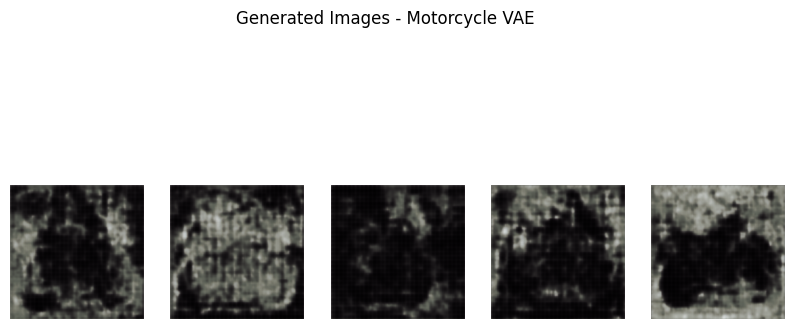

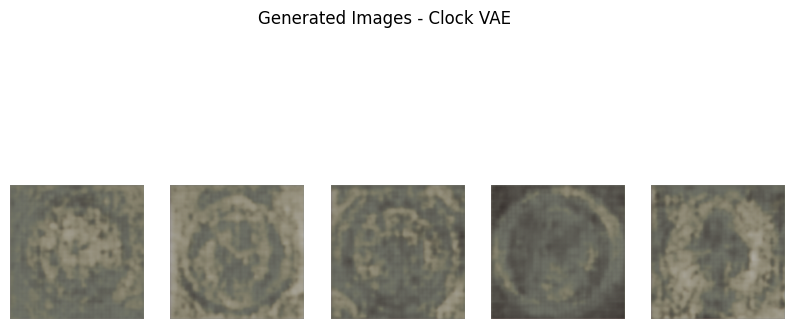

In [26]:
# Celda 6: Visualización y registro de imágenes generadas en WandB

def display_generated_images(gen_images, title):
    plt.figure(figsize=(10, 5))
    n = min(5, gen_images.shape[0])
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualización para Motorcycle VAE
display_generated_images(gen_images_moto, "Generated Images - Motorcycle VAE")

# Visualización para Clock VAE
display_generated_images(gen_images_clock, "Generated Images - Clock VAE")

# Registro de imágenes en WandB
run_vis = wandb.init(project="VAE + DAE", name="Generated_Images", reinit=True)
wandb.log({
    "Generated_Images_Motorcycle": [wandb.Image(img) for img in gen_images_moto[:5]],
    "Generated_Images_Clock": [wandb.Image(img) for img in gen_images_clock[:5]]
})
wandb.finish()

In [ ]:
# Celda 7: Creación de la interfaz interactiva con Gradio

import gradio as gr

def generate_images(class_choice, num_images):
    # Semilla para mantener reproducibilidad en la generación
    np.random.seed(seed)
    if class_choice.lower() == "motorcycle":
        z_samples = np.random.normal(size=(num_images, LATENT_DIM))
        generated = decoder_moto.predict(z_samples)
    elif class_choice.lower() == "clock":
        z_samples = np.random.normal(size=(num_images, LATENT_DIM))
        generated = decoder_clock.predict(z_samples)
    else:
        return "Clase no reconocida. Elige 'Motorcycle' o 'Clock'."
    # Retornar lista de imágenes
    return [generated[i] for i in range(num_images)]

iface = gr.Interface(
    fn=generate_images,
    inputs=[
        gr.inputs.Dropdown(choices=["Motorcycle", "Clock"], label="Clase"),
        gr.inputs.Slider(minimum=1, maximum=10, step=1, default=5, label="Número de Imágenes")
    ],
    outputs=gr.outputs.Gallery(label="Imágenes Generadas"),
    title="Generación de Imágenes con VAE Individual por Clase",
    description="Selecciona una clase y el número de imágenes a generar."
)

iface.launch()

In [ ]:
# Celda 8: Placeholder para la implementación del DAE
# Aquí se implementará el Denoising Autoencoder (DAE) siguiendo:
# - Agregar ruido (Gaussiano, sal y pimienta) a las imágenes de entrenamiento.
# - Entrenar el DAE y evaluarlo con imágenes ruidosas.
# - Registrar entrenamiento y métricas en WandB.
print("Implementación del DAE pendiente.")

---

# Hasta aqui llevamos

Esto proporcionará un link donde interactuar con la app. En Colab, `debug=False` evita log verbose; también se puede usar `share=True` para obtener un enlace público aunque W&B y HF Spaces suelen ser mejores para compartir formalmente.

### 4.2 Despliegue en Hugging Face Spaces con Autenticación
Para desplegar esta demo en Hugging Face Spaces, necesitamos:
1. Tener una cuenta en Hugging Face y un **token de autenticación** con permisos de *write*.
2. Crear un nuevo Space (por ejemplo, en la web de Hugging Face, podemos crear un Space de tipo Gradio, repositorio vacío).
3. Desde Colab, clonaremos ese repositorio Space, añadiremos nuestro código de la app (un archivo `app.py` con la interfaz Gradio, requisitos, etc.), y luego haremos push.

Instalemos la herramienta de Huggingface Hub:

In [ ]:
!pip install huggingface_hub
from huggingface_hub import HfApi, Repository, login

# Login a Hugging Face using token (reemplaza 'YOUR_HF_TOKEN' con el tuyo)
login(token="YOUR_HF_TOKEN")

A continuación, clonamos el repositorio del Space. Debes reemplazar `"usuario/nombre-del-space"` con tu usuario de HF y el nombre que hayas elegido para el Space:

In [ ]:
# Clonar el repositorio del Space
repo_url = "https://huggingface.co/spaces/usuario/nombre-del-space"
local_dir = "my_gradio_space"
repo = Repository(local_dir=local_dir, clone_from=repo_url)

Ahora debemos preparar los archivos para el Space:
- Un archivo `app.py` con la aplicación Gradio (similar a lo que definimos arriba).
- Un archivo `requirements.txt` listando las dependencias (e.g., `gradio`, `tensorflow`, `wandb` si se necesita, etc.). En este caso necesitaremos al menos `gradio` y `tensorflow` para que el Space instale esas librerías.
- Los archivos de modelo guardados (`dae_model.h5`, `vae_decoder.h5`, etc.) deben ser incluidos en el repo, ya que la app los cargará para funcionar. Alternativamente, podemos subirlos como *datasets* o *artifacts* y hacer que la app los descargue, pero es más sencillo adjuntarlos al Space dado que no son muy pesados para este ejemplo.

Crearemos el archivo `app.py` dentro de nuestro repositorio clonado:

In [ ]:
%%bash
cat > my_gradio_space/app.py << 'PYCODE'

In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Cargar modelos (asume que los .h5 están en el mismo directorio en el Space)
dae_model = load_model("dae_model.h5")
decoder = load_model("vae_decoder.h5")
latent_dim = decoder.inputs[0].shape[-1]  # obtener dim latente desde el modelo

def denoise_image(input_img):
    img = input_img.resize((64, 64)).convert("RGB")
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Añadir ruido (gaussiano o sal&pimienta aleatoriamente)
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 0.1, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 1)
    else:
        noisy = img_array.copy()
        prob = 0.1
        rnd = np.random.rand(*img_array.shape)
        noisy[rnd < prob/2] = 0.0
        noisy[rnd > 1 - prob/2] = 1.0
    # Pasar por DAE
    output = dae_model.predict(noisy[np.newaxis, ...])[0]
    noisy_img = Image.fromarray((noisy * 255).astype('uint8'))
    output_img = Image.fromarray((output * 255).astype('uint8'))
    return noisy_img, output_img

def generate_image(seed):
    if seed is not None:
        np.random.seed(int(seed))
    z = np.random.normal(size=(1, latent_dim))
    gen = decoder.predict(z)[0]
    gen_img = Image.fromarray((gen * 255).astype('uint8'))
    return gen_img

dae_interface = gr.Interface(fn=denoise_image,
                             inputs=gr.Image(label="Sube una imagen"),
                             outputs=[gr.Image(label="Imagen con ruido"), gr.Image(label="Imagen denoised")],
                             title="Denoising Autoencoder",
                             description="Sube una imagen de una moto o auto, el modelo le añadirá ruido y luego intentará limpiarla.")
vae_interface = gr.Interface(fn=generate_image,
                             inputs=gr.Number(label="Semilla (opcional)"),
                             outputs=gr.Image(label="Imagen generada"),
                             title="Variational Autoencoder",
                             description="Genera una imagen de moto/auto sintética a partir de un vector aleatorio (puedes cambiar la semilla para reproducir resultados).")

demo = gr.TabbedInterface([dae_interface, vae_interface], ["DAE - Denoise", "VAE - Generate"])
demo.launch()

También creamos el `requirements.txt`:


In [ ]:
%%bash
echo "gradio\ntensorflow==2.9.2" > my_gradio_space/requirements.txt

*(Nota: especificamos una versión de TensorFlow compatible con el entorno de Spaces. También podríamos añadir `wandb` si quisiéramos que la app integre tracking, pero para inferencia no es necesario.)*

Ahora movemos los archivos de modelo guardados al directorio del Space:

In [ ]:
!cp dae_model.h5 my_gradio_space/
!cp vae_decoder.h5 my_gradio_space/

Finalmente, hacemos commit y push al repositorio del Space:

In [ ]:
repo.push_to_hub(commit_message="Initial commit - add Gradio app and models")



Tras unos minutos (que el Space instale dependencias y arranque), la app debería estar disponible en `https://huggingface.co/spaces/usuario/nombre-del-space`. Si el Space es **privado**, solo usuarios con acceso (o con el token) podrán verlo; si es público, cualquiera puede interactuar con la demo. Podemos controlar la visibilidad desde la configuración del Space en Hugging Face.

**Autenticación**: En el código de despliegue, autenticamos con `login(token=...)` para poder clonar y subir al Space. Asegúrate de mantener tu token seguro (no compartirlo públicamente). Una práctica común es almacenarlo como variable de entorno o usar la interfaz de Colab para introducirlo en lugar de hardcodearlo en el notebook.

## 5. Automatización y Eficiencia en Colab
En esta última sección, resumimos estrategias empleadas y recomendaciones para ejecutar eficientemente este pipeline en Google Colab (u otros entornos similares):

- **Carga de Datos en Batches**: En lugar de cargar todas las imágenes a la vez en la GPU, usamos `tf.data` para cargar por lotes y añadimos ruido sobre la marcha. Esto reduce el pico de memoria y aprovecha el *pipeline* asíncrono para alimentar la GPU constantemente.
- **Liberación de Memoria**: Después de entrenar el DAE, liberamos recursos (modelo y grafo de TF) antes de iniciar el VAE. Esto se hizo con `del modelo`, `clear_session()` y `gc.collect()`, evitando acumulación de uso de GPU/CPU RAM.
- **Monitorización con W&B**: Usamos W&B no solo para métricas sino también para almacenar los modelos y pesos. De esta forma, si Colab se desconecta o reinicia, podemos recuperar los modelos entrenados desde W&B fácilmente (usando artefactos). Automatizar el registro y carga de artefactos en W&B asegura que no se pierda el trabajo y facilita reproducibilidad.
- **Uso eficiente de GPU**: Nos aseguramos de utilizar `.prefetch` en los datasets para que la GPU no espere por datos. También configuramos un tamaño de batch razonable (32) que quepa en memoria pero que aproveche paralelismo. En Colab, activar el **entorno de ejecución GPU** es esencial (Runtime > Change runtime type > GPU).
- **Mixed Precision (opcional)**: Como mencionamos, aprovechar `mixed_precision` en GPUs compatibles (como Tesla T4 o superiores en Colab) puede acelerar entrenamiento y reducir consumo de memoria, lo cual es valioso en VAEs u otros modelos grandes.
- **Modularización del Código**: Organizamos el código en funciones (`build_dae`, funciones de ruido, etc.) y secciones lógicas separadas, lo que facilita pruebas por separado (por ejemplo, podríamos probar el DAE sin involucrar el VAE) y mantiene el notebook ordenado. Esto es útil para automatización, ya que podemos reusar componentes. Además, colocamos todo en un único notebook secuencialmente, permitiendo ejecutar todo de corrido en Colab, con las dependencias instaladas al inicio y los pasos bien documentados.
- **Registro de Resultados y Modelos**: Además de W&B, guardamos localmente los modelos (`.h5`) para fácilmente integrarlos a la demo. Esto muestra una práctica de guardar checkpoints de modelos durante el pipeline, lo que es recomendable para no tener que reentrenar desde cero si ocurre algún problema.

Con todo lo anterior, hemos logrado un flujo de trabajo completo: desde la **obtención de datos**, pasando por el **entrenamiento** de dos modelos de autoencoder con diferentes fines (eliminación de ruido y generación de datos), hasta una **demostración interactiva** y su despliegue, aplicando buenas prácticas de eficiencia y seguimiento de experimentos en un entorno de GPU como Colab.

¡Ahora el notebook está listo para ejecutarse paso a paso en Google Colab y reproducir el proyecto de principio a fin!